# Training Model - Identifikasi Suara dengan Speaker Verification

## Tujuan
Membuat model yang bisa:
1. **Mengidentifikasi speaker** (Nadia atau Ufi)
2. **Mengklasifikasi action** (Buka atau Tutup)
3. **Menolak suara dari orang lain** (speaker verification)

## Dataset
- **Nadia**: ~110 file buka, ~110 file tutup (audio_data2/BukaTutup_nadia/)
- **Ufi**: audio files di audio_data2/BukaTutup_ufi/Rekaman/

## Output
- Model classifier (.pkl)
- Scaler (.pkl)
- Label encoder (.pkl)
- Metadata (.pkl)

## 1. Import Libraries

In [1]:
# Library untuk manipulasi data
import numpy as np
import pandas as pd
import os
from glob import glob
from datetime import datetime

# Library untuk audio processing
import librosa
import librosa.display

# Library untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Library untuk save/load model
import joblib

# Library untuk statistik
from scipy import stats

# Pengaturan visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

print("✅ Semua library berhasil diimport!")

✅ Semua library berhasil diimport!


## 2. Fungsi Ekstraksi Features

Kita akan mengekstrak features yang relevan untuk **speaker identification** dan **action classification**:

### Features untuk Speaker Identification:
- **MFCC (Mel-Frequency Cepstral Coefficients)**: Karakteristik unik dari suara manusia
- **Pitch/F0**: Frekuensi fundamental suara
- **Spectral features**: Centroid, rolloff, bandwidth

### Features untuk Action Classification:
- **Energy/RMS**: Kekuatan sinyal
- **Zero Crossing Rate**: Tingkat perubahan sinyal
- **Temporal features**: Duration, gradient

In [2]:
def extract_comprehensive_features(audio, sr):
    """
    Ekstraksi features untuk speaker identification & action classification
    
    Parameters:
    -----------
    audio : numpy array
        Sinyal audio
    sr : int
        Sampling rate
    
    Returns:
    --------
    features : dict
        Dictionary dengan ~70 features
    """
    features = {}
    
    # ===== 1. TIME DOMAIN FEATURES (Action Classification) =====
    features['mean'] = np.mean(audio)
    features['std'] = np.std(audio)
    features['max'] = np.max(audio)
    features['min'] = np.min(audio)
    features['median'] = np.median(audio)
    features['variance'] = np.var(audio)
    features['skewness'] = stats.skew(audio)
    features['kurtosis'] = stats.kurtosis(audio)
    features['range'] = np.ptp(audio)
    features['iqr'] = stats.iqr(audio)
    
    # Energy features
    features['energy'] = np.sum(audio**2)
    features['rms'] = np.sqrt(np.mean(audio**2))
    features['zcr'] = np.mean(librosa.feature.zero_crossing_rate(audio))
    
    # Temporal features
    features['duration'] = len(audio) / sr
    gradient = np.gradient(audio)
    features['mean_gradient'] = np.mean(np.abs(gradient))
    features['max_gradient'] = np.max(np.abs(gradient))
    
    # Percentiles
    features['percentile_25'] = np.percentile(audio, 25)
    features['percentile_75'] = np.percentile(audio, 75)
    
    # ===== 2. SPECTRAL FEATURES (Speaker + Action) =====
    # Spectral centroid
    spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
    features['spectral_centroid_mean'] = np.mean(spectral_centroids)
    features['spectral_centroid_std'] = np.std(spectral_centroids)
    features['spectral_centroid_max'] = np.max(spectral_centroids)
    features['spectral_centroid_min'] = np.min(spectral_centroids)
    
    # Spectral rolloff
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)[0]
    features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
    features['spectral_rolloff_std'] = np.std(spectral_rolloff)
    
    # Spectral bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)[0]
    features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
    features['spectral_bandwidth_std'] = np.std(spectral_bandwidth)
    
    # Spectral contrast
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    features['spectral_contrast_mean'] = np.mean(spectral_contrast)
    features['spectral_contrast_std'] = np.std(spectral_contrast)
    
    # ===== 3. MFCC (CRITICAL for Speaker Identification) =====
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
    for i in range(20):
        features[f'mfcc_{i+1}_mean'] = np.mean(mfccs[i])
        features[f'mfcc_{i+1}_std'] = np.std(mfccs[i])
        features[f'mfcc_{i+1}_max'] = np.max(mfccs[i])
    
    # ===== 4. PITCH/F0 (Speaker Characteristic) =====
    try:
        # Ekstrak pitch menggunakan pyin
        f0, voiced_flag, voiced_probs = librosa.pyin(
            audio, 
            fmin=librosa.note_to_hz('C2'), 
            fmax=librosa.note_to_hz('C7'),
            sr=sr
        )
        # Hapus NaN values
        f0_clean = f0[~np.isnan(f0)]
        
        if len(f0_clean) > 0:
            features['pitch_mean'] = np.mean(f0_clean)
            features['pitch_std'] = np.std(f0_clean)
            features['pitch_max'] = np.max(f0_clean)
            features['pitch_min'] = np.min(f0_clean)
            features['pitch_range'] = features['pitch_max'] - features['pitch_min']
        else:
            features['pitch_mean'] = 0
            features['pitch_std'] = 0
            features['pitch_max'] = 0
            features['pitch_min'] = 0
            features['pitch_range'] = 0
    except:
        features['pitch_mean'] = 0
        features['pitch_std'] = 0
        features['pitch_max'] = 0
        features['pitch_min'] = 0
        features['pitch_range'] = 0
    
    # ===== 5. CHROMA FEATURES (Pitch class) =====
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    features['chroma_mean'] = np.mean(chroma)
    features['chroma_std'] = np.std(chroma)
    
    return features

print("✅ Fungsi ekstraksi features siap!")
print("📊 Total features: ~90 features (termasuk 20 MFCC x 3 statistik)")

✅ Fungsi ekstraksi features siap!
📊 Total features: ~90 features (termasuk 20 MFCC x 3 statistik)


## 3. Load Audio Files dan Buat Dataset

Dataset structure:
```
audio_data2/
├── BukaTutup_nadia/
│   ├── buka*.mp3
│   └── tutup*.mp3
└── BukaTutup_ufi/
    └── Rekaman/
        ├── Buka/*.wav
        └── tutup/*.wav
```

Label format: **`{speaker}_{action}`**
- `nadia_buka`
- `nadia_tutup`
- `ufi_buka`
- `ufi_tutup`

In [3]:
def load_audio(file_path, sr=22050, duration=None):
    """
    Load audio file
    """
    try:
        audio, _ = librosa.load(file_path, sr=sr, duration=duration)
        return audio, sr
    except Exception as e:
        print(f"⚠️  Error loading {file_path}: {str(e)}")
        return None, None

def create_speaker_dataset(base_path='audio_data2', sr=22050, max_duration=5):
    """
    Membuat dataset dengan label speaker_action
    
    Returns:
    --------
    df : pandas DataFrame
        Dataset dengan features dan multi-label
    """
    data = []
    
    print("="*70)
    print("🎵 LOADING AUDIO FILES")
    print("="*70)
    
    # ===== 1. NADIA =====
    nadia_path = os.path.join(base_path, 'BukaTutup_nadia')
    print(f"\n📁 Processing NADIA's audio from: {nadia_path}")
    
    # Nadia - Buka
    nadia_buka_files = glob(os.path.join(nadia_path, 'buka*.mp3'))
    print(f"   → Buka: {len(nadia_buka_files)} files")
    
    for i, file_path in enumerate(nadia_buka_files):
        audio, sr_loaded = load_audio(file_path, sr=sr, duration=max_duration)
        if audio is not None:
            features = extract_comprehensive_features(audio, sr_loaded)
            features['label'] = 'nadia_buka'
            features['speaker'] = 'nadia'
            features['action'] = 'buka'
            features['filename'] = os.path.basename(file_path)
            data.append(features)
        
        if (i + 1) % 20 == 0:
            print(f"      Progress: {i + 1}/{len(nadia_buka_files)}")
    
    # Nadia - Tutup
    nadia_tutup_files = glob(os.path.join(nadia_path, 'tutup*.mp3'))
    print(f"   → Tutup: {len(nadia_tutup_files)} files")
    
    for i, file_path in enumerate(nadia_tutup_files):
        audio, sr_loaded = load_audio(file_path, sr=sr, duration=max_duration)
        if audio is not None:
            features = extract_comprehensive_features(audio, sr_loaded)
            features['label'] = 'nadia_tutup'
            features['speaker'] = 'nadia'
            features['action'] = 'tutup'
            features['filename'] = os.path.basename(file_path)
            data.append(features)
        
        if (i + 1) % 20 == 0:
            print(f"      Progress: {i + 1}/{len(nadia_tutup_files)}")
    
    # ===== 2. UFI =====
    ufi_path = os.path.join(base_path, 'BukaTutup_ufi/Rekaman')
    print(f"\n📁 Processing UFI's audio from: {ufi_path}")
    
    # Ufi - Buka
    ufi_buka_path = os.path.join(ufi_path, 'Buka')
    ufi_buka_files = glob(os.path.join(ufi_buka_path, '*.wav'))
    ufi_buka_files += glob(os.path.join(ufi_buka_path, '*.mp3'))
    print(f"   → Buka: {len(ufi_buka_files)} files")
    
    for i, file_path in enumerate(ufi_buka_files):
        audio, sr_loaded = load_audio(file_path, sr=sr, duration=max_duration)
        if audio is not None:
            features = extract_comprehensive_features(audio, sr_loaded)
            features['label'] = 'ufi_buka'
            features['speaker'] = 'ufi'
            features['action'] = 'buka'
            features['filename'] = os.path.basename(file_path)
            data.append(features)
        
        if (i + 1) % 20 == 0:
            print(f"      Progress: {i + 1}/{len(ufi_buka_files)}")
    
    # Ufi - Tutup
    ufi_tutup_path = os.path.join(ufi_path, 'tutup')
    ufi_tutup_files = glob(os.path.join(ufi_tutup_path, '*.wav'))
    ufi_tutup_files += glob(os.path.join(ufi_tutup_path, '*.mp3'))
    print(f"   → Tutup: {len(ufi_tutup_files)} files")
    
    for i, file_path in enumerate(ufi_tutup_files):
        audio, sr_loaded = load_audio(file_path, sr=sr, duration=max_duration)
        if audio is not None:
            features = extract_comprehensive_features(audio, sr_loaded)
            features['label'] = 'ufi_tutup'
            features['speaker'] = 'ufi'
            features['action'] = 'tutup'
            features['filename'] = os.path.basename(file_path)
            data.append(features)
        
        if (i + 1) % 20 == 0:
            print(f"      Progress: {i + 1}/{len(ufi_tutup_files)}")
    
    # ===== CREATE DATAFRAME =====
    print("\n" + "="*70)
    
    if len(data) == 0:
        print("❌ ERROR: Tidak ada data yang berhasil diproses!")
        return None
    
    df = pd.DataFrame(data)
    
    print("✅ DATASET BERHASIL DIBUAT!")
    print("="*70)
    print(f"\n📊 Dataset Info:")
    print(f"   Total samples: {len(df)}")
    print(f"   Total features: {len([col for col in df.columns if col not in ['label', 'speaker', 'action', 'filename']])}")
    print(f"\n📋 Distribusi Label (Speaker_Action):")
    print(df['label'].value_counts())
    print(f"\n👥 Distribusi Speaker:")
    print(df['speaker'].value_counts())
    print(f"\n🎬 Distribusi Action:")
    print(df['action'].value_counts())
    
    return df

print("✅ Fungsi create_speaker_dataset siap!")

✅ Fungsi create_speaker_dataset siap!


## 4. Extract Features dari Audio Files

In [4]:
# Load dan ekstrak features dari semua audio
df = create_speaker_dataset(base_path='audio_data2', sr=22050, max_duration=5)

if df is not None:
    # Simpan dataset
    df.to_csv('speaker_audio_features.csv', index=False)
    print(f"\n💾 Dataset disimpan sebagai 'speaker_audio_features.csv'")

🎵 LOADING AUDIO FILES

📁 Processing NADIA's audio from: audio_data2/BukaTutup_nadia
   → Buka: 110 files


Note: Illegal Audio-MPEG-Header 0x34332c33 at offset 58560.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x382c3231 at offset 48960.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x382c3231 at offset 48960.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x332c3732 at offset 70080.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x332c3732 at offset 70080.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x37302c37 at offset 94080.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x37302c37 at offset 94080.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x312c3433 at offset 68

      Progress: 20/110


Note: Illegal Audio-MPEG-Header 0x362c3136 at offset 71040.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x3533382c at offset 47040.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x3533382c at offset 47040.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x392c3236 at offset 48960.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x392c3236 at offset 48960.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x302c3231 at offset 53760.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x302c3231 at offset 53760.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x3135352c at offset 61

      Progress: 40/110


Note: Illegal Audio-MPEG-Header 0x35352c35 at offset 42240.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x372c3437 at offset 70080.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x372c3437 at offset 70080.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x322c3237 at offset 36480.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x322c3237 at offset 36480.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x32392c32 at offset 89280.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x32392c32 at offset 89280.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x322c3332 at offset 48

      Progress: 60/110


Note: Illegal Audio-MPEG-Header 0x3134342c at offset 46080.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x38332c31 at offset 48960.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x38332c31 at offset 48960.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x392c3233 at offset 32640.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x392c3233 at offset 32640.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x392c3234 at offset 37440.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x392c3234 at offset 37440.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x312c3236 at offset 65

      Progress: 80/110


Note: Illegal Audio-MPEG-Header 0x372c3630 at offset 44160.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x312c3537 at offset 36480.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x312c3537 at offset 36480.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x352c3337 at offset 68160.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x352c3337 at offset 68160.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x332c3639 at offset 53760.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x332c3639 at offset 53760.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x382c3431 at offset 55

      Progress: 100/110


Note: Illegal Audio-MPEG-Header 0x372c3231 at offset 47040.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x382c3736 at offset 37440.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x382c3736 at offset 37440.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x352c3330 at offset 47040.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x352c3330 at offset 47040.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x302c3333 at offset 90240.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x302c3333 at offset 90240.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x352c3331 at offset 44

   → Tutup: 110 files


Note: Illegal Audio-MPEG-Header 0x382c3131 at offset 37440.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x342c3337 at offset 39360.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x342c3337 at offset 39360.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x33352c32 at offset 44160.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x33352c32 at offset 44160.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x352c3631 at offset 36480.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x352c3631 at offset 36480.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x3737322c at offset 32

      Progress: 20/110


Note: Illegal Audio-MPEG-Header 0x362c3335 at offset 32640.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x312c3634 at offset 37440.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x312c3634 at offset 37440.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x362c3239 at offset 39360.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x362c3239 at offset 39360.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x382c3136 at offset 47040.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x382c3136 at offset 47040.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x392c3236 at offset 32

      Progress: 40/110


Note: Illegal Audio-MPEG-Header 0x372c3330 at offset 47040.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x392c3232 at offset 41280.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x392c3232 at offset 41280.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x322c3338 at offset 42240.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x322c3338 at offset 42240.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x362c3334 at offset 41280.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x362c3334 at offset 41280.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x2c32382c at offset 37

      Progress: 60/110


Note: Illegal Audio-MPEG-Header 0x322c3334 at offset 36480.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x33362c32 at offset 42240.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x33362c32 at offset 42240.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x302c3234 at offset 46080.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x302c3234 at offset 46080.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x302c3133 at offset 44160.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x302c3133 at offset 44160.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x362c3331 at offset 48

      Progress: 80/110


Note: Illegal Audio-MPEG-Header 0x3638362c at offset 37440.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x372c3333 at offset 39360.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x372c3333 at offset 39360.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x342c3536 at offset 27840.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x342c3536 at offset 27840.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x342c3333 at offset 36480.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x342c3333 at offset 36480.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x392c3530 at offset 37

      Progress: 100/110


Note: Illegal Audio-MPEG-Header 0x372c3235 at offset 41280.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x33392c35 at offset 41280.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x33392c35 at offset 41280.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x312c3237 at offset 42240.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x312c3237 at offset 42240.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x322c3237 at offset 37440.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x322c3237 at offset 37440.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x342c3235 at offset 46


📁 Processing UFI's audio from: audio_data2/BukaTutup_ufi/Rekaman
   → Buka: 80 files
      Progress: 20/80
      Progress: 20/80
      Progress: 40/80
      Progress: 40/80
      Progress: 60/80
      Progress: 60/80
      Progress: 80/80
   → Tutup: 80 files
      Progress: 80/80
   → Tutup: 80 files
      Progress: 20/80
      Progress: 20/80
      Progress: 40/80
      Progress: 40/80
      Progress: 60/80
      Progress: 60/80
      Progress: 80/80

✅ DATASET BERHASIL DIBUAT!

📊 Dataset Info:
   Total samples: 380
   Total features: 95

📋 Distribusi Label (Speaker_Action):
label
nadia_buka     110
nadia_tutup    110
ufi_buka        80
ufi_tutup       80
Name: count, dtype: int64

👥 Distribusi Speaker:
speaker
nadia    220
ufi      160
Name: count, dtype: int64

🎬 Distribusi Action:
action
buka     190
tutup    190
Name: count, dtype: int64

💾 Dataset disimpan sebagai 'speaker_audio_features.csv'
      Progress: 80/80

✅ DATASET BERHASIL DIBUAT!

📊 Dataset Info:
   Total samples: 3

## 5. Data Preprocessing & Train-Test Split

In [5]:
def prepare_data_for_training(df, test_size=0.2, random_state=42):
    """
    Prepare data untuk training
    """
    print("="*70)
    print("⚙️ DATA PREPROCESSING")
    print("="*70)
    
    # Drop metadata columns
    metadata_cols = ['label', 'speaker', 'action', 'filename']
    X = df.drop(columns=metadata_cols, errors='ignore')
    y = df['label']
    
    # Handle missing values
    if X.isnull().any().any():
        print("⚠️  Ditemukan missing values, mengisi dengan median...")
        X = X.fillna(X.median())
    
    # Handle infinite values
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())
    
    print(f"\n📊 Dataset Info:")
    print(f"   Features: {X.shape[1]}")
    print(f"   Samples: {X.shape[0]}")
    print(f"   Labels: {y.nunique()} classes {list(y.unique())}")
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Train-test split (stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, 
        test_size=test_size, 
        random_state=random_state, 
        stratify=y_encoded
    )
    
    print(f"\n✂️ Data Split:")
    print(f"   Training: {len(X_train)} samples ({(1-test_size)*100:.0f}%)")
    print(f"   Testing: {len(X_test)} samples ({test_size*100:.0f}%)")
    
    # Normalisasi dengan StandardScaler
    print(f"\n📏 Normalisasi features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"   Mean: ~{X_train_scaled.mean():.4f}")
    print(f"   Std: ~{X_train_scaled.std():.4f}")
    
    print(f"\n✅ Preprocessing selesai!")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, label_encoder, X.columns.tolist()

# Jalankan preprocessing
X_train, X_test, y_train, y_test, scaler, label_encoder, feature_names = prepare_data_for_training(df)

⚙️ DATA PREPROCESSING

📊 Dataset Info:
   Features: 95
   Samples: 380
   Labels: 4 classes ['nadia_buka', 'nadia_tutup', 'ufi_buka', 'ufi_tutup']

✂️ Data Split:
   Training: 304 samples (80%)
   Testing: 76 samples (20%)

📏 Normalisasi features...
   Mean: ~0.0000
   Std: ~1.0000

✅ Preprocessing selesai!


## 6. Model Training & Evaluation

Kita akan mencoba beberapa model:
1. **Random Forest** - Baik untuk multi-class classification
2. **Gradient Boosting** - Performa tinggi
3. **SVM** - Bagus untuk high-dimensional data
4. **KNN** - Baseline model

🤖 MODEL TRAINING & EVALUATION

📊 Random Forest
⏳ Training...

✅ Test Accuracy: 1.0000 (100.00%)

📋 Classification Report:
              precision    recall  f1-score   support

  nadia_buka       1.00      1.00      1.00        22
 nadia_tutup       1.00      1.00      1.00        22
    ufi_buka       1.00      1.00      1.00        16
   ufi_tutup       1.00      1.00      1.00        16

    accuracy                           1.00        76
   macro avg       1.00      1.00      1.00        76
weighted avg       1.00      1.00      1.00        76


🔄 Cross-Validation (5-fold):

✅ Test Accuracy: 1.0000 (100.00%)

📋 Classification Report:
              precision    recall  f1-score   support

  nadia_buka       1.00      1.00      1.00        22
 nadia_tutup       1.00      1.00      1.00        22
    ufi_buka       1.00      1.00      1.00        16
   ufi_tutup       1.00      1.00      1.00        16

    accuracy                           1.00        76
   macro avg       1.00   

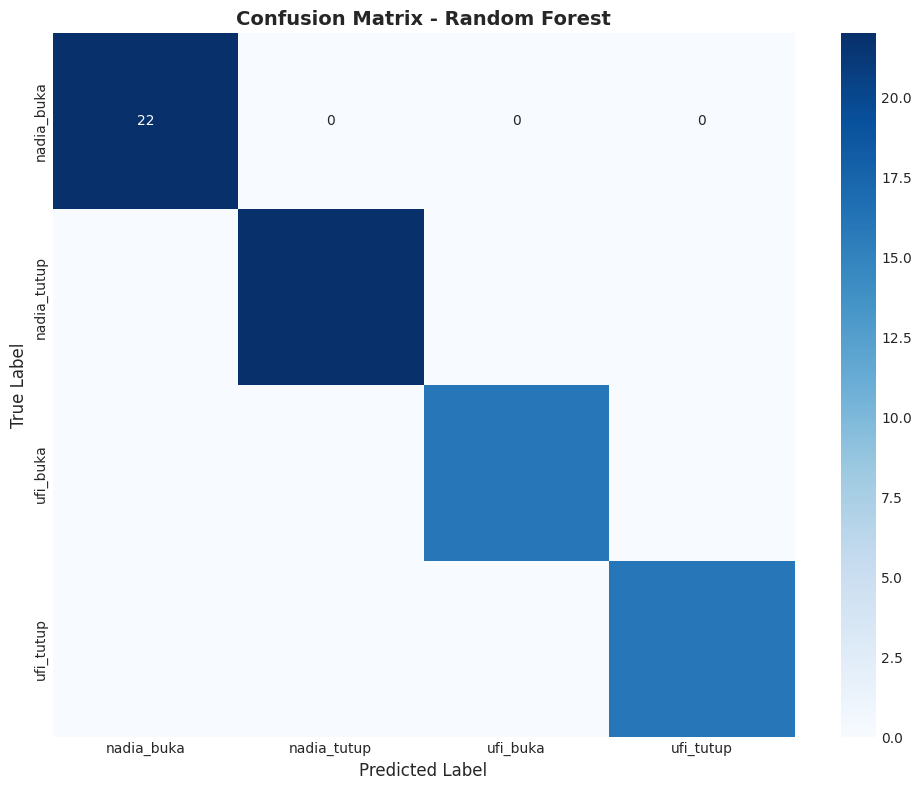


📊 Gradient Boosting
⏳ Training...

✅ Test Accuracy: 0.8947 (89.47%)

📋 Classification Report:
              precision    recall  f1-score   support

  nadia_buka       1.00      0.95      0.98        22
 nadia_tutup       0.79      1.00      0.88        22
    ufi_buka       0.85      0.69      0.76        16
   ufi_tutup       1.00      0.88      0.93        16

    accuracy                           0.89        76
   macro avg       0.91      0.88      0.89        76
weighted avg       0.91      0.89      0.89        76


🔄 Cross-Validation (5-fold):

✅ Test Accuracy: 0.8947 (89.47%)

📋 Classification Report:
              precision    recall  f1-score   support

  nadia_buka       1.00      0.95      0.98        22
 nadia_tutup       0.79      1.00      0.88        22
    ufi_buka       0.85      0.69      0.76        16
   ufi_tutup       1.00      0.88      0.93        16

    accuracy                           0.89        76
   macro avg       0.91      0.88      0.89        76


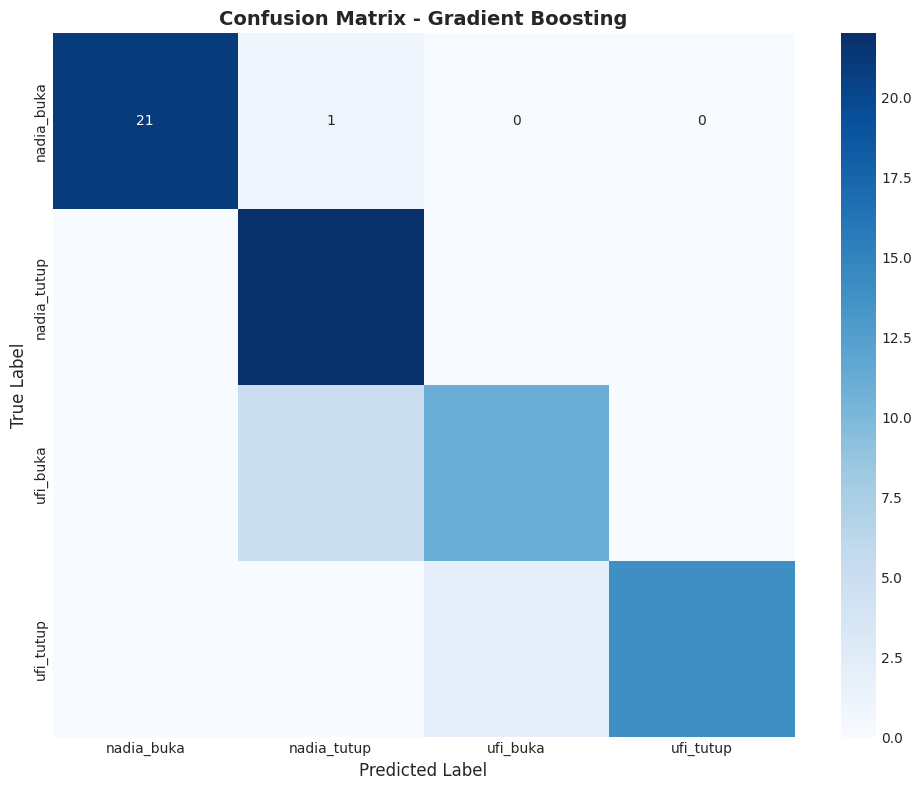


📊 SVM
⏳ Training...

✅ Test Accuracy: 1.0000 (100.00%)

📋 Classification Report:
              precision    recall  f1-score   support

  nadia_buka       1.00      1.00      1.00        22
 nadia_tutup       1.00      1.00      1.00        22
    ufi_buka       1.00      1.00      1.00        16
   ufi_tutup       1.00      1.00      1.00        16

    accuracy                           1.00        76
   macro avg       1.00      1.00      1.00        76
weighted avg       1.00      1.00      1.00        76


🔄 Cross-Validation (5-fold):
   CV Scores: ['1.0000', '1.0000', '1.0000', '1.0000', '1.0000']
   Mean: 1.0000 (+/- 0.0000)


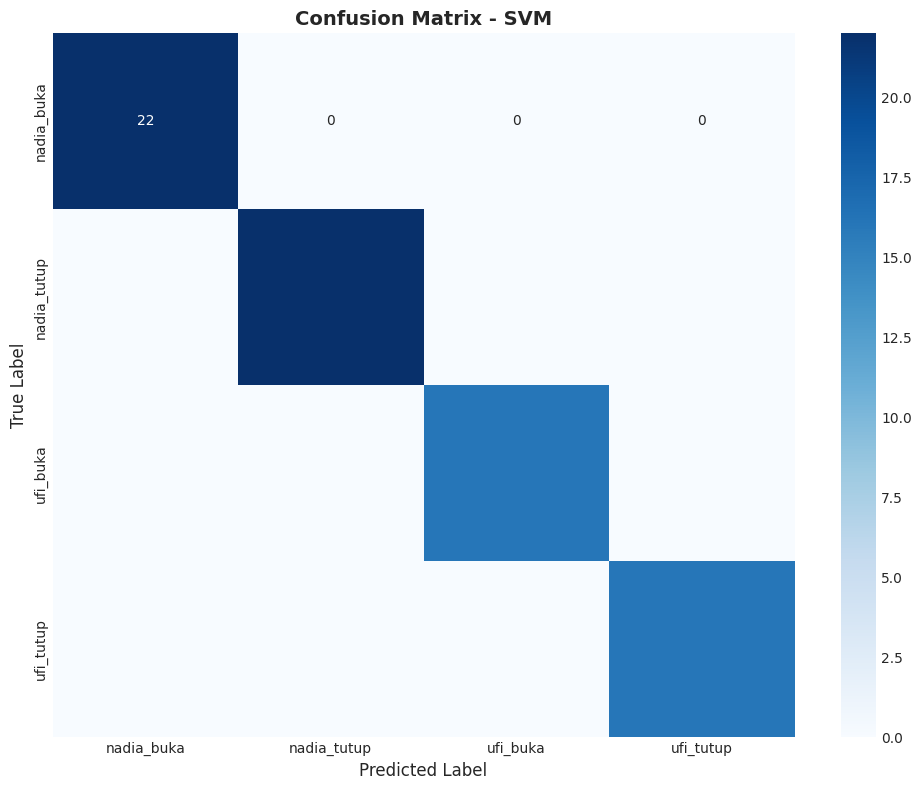


📊 KNN
⏳ Training...

✅ Test Accuracy: 1.0000 (100.00%)

📋 Classification Report:
              precision    recall  f1-score   support

  nadia_buka       1.00      1.00      1.00        22
 nadia_tutup       1.00      1.00      1.00        22
    ufi_buka       1.00      1.00      1.00        16
   ufi_tutup       1.00      1.00      1.00        16

    accuracy                           1.00        76
   macro avg       1.00      1.00      1.00        76
weighted avg       1.00      1.00      1.00        76


🔄 Cross-Validation (5-fold):
   CV Scores: ['1.0000', '1.0000', '0.9672', '1.0000', '1.0000']
   Mean: 0.9934 (+/- 0.0262)

✅ Test Accuracy: 1.0000 (100.00%)

📋 Classification Report:
              precision    recall  f1-score   support

  nadia_buka       1.00      1.00      1.00        22
 nadia_tutup       1.00      1.00      1.00        22
    ufi_buka       1.00      1.00      1.00        16
   ufi_tutup       1.00      1.00      1.00        16

    accuracy              

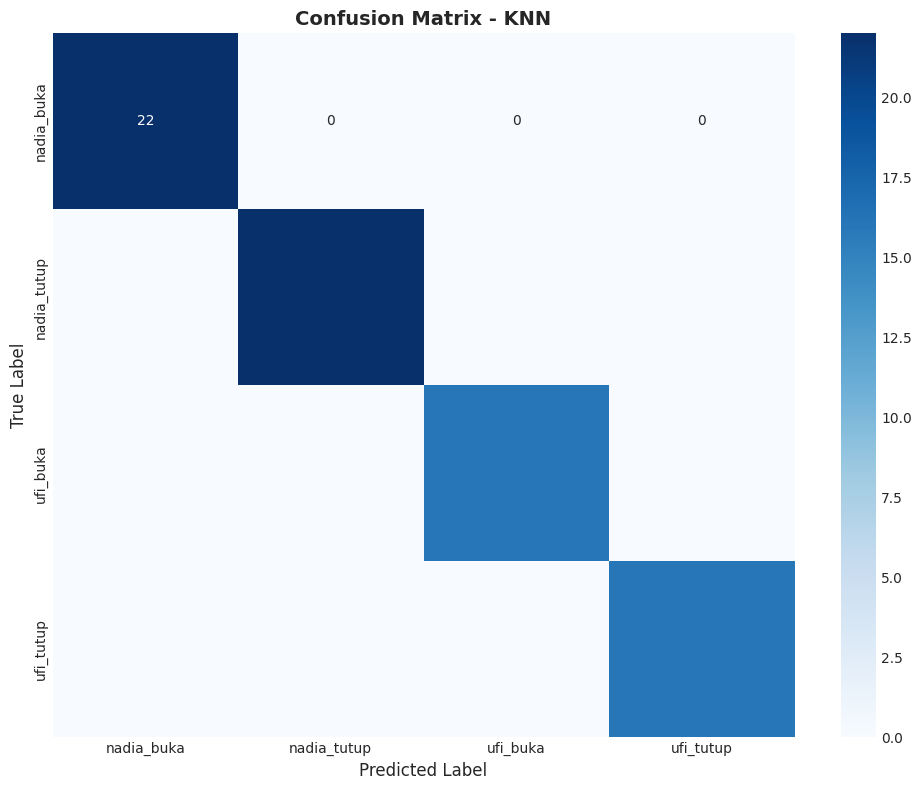


📊 MODEL COMPARISON SUMMARY

             Model  Test Accuracy  CV Mean   CV Std
    Random Forest       1.000000 1.000000 0.000000
              SVM       1.000000 1.000000 0.000000
              KNN       1.000000 0.993443 0.013115
Gradient Boosting       0.894737 0.947486 0.039294


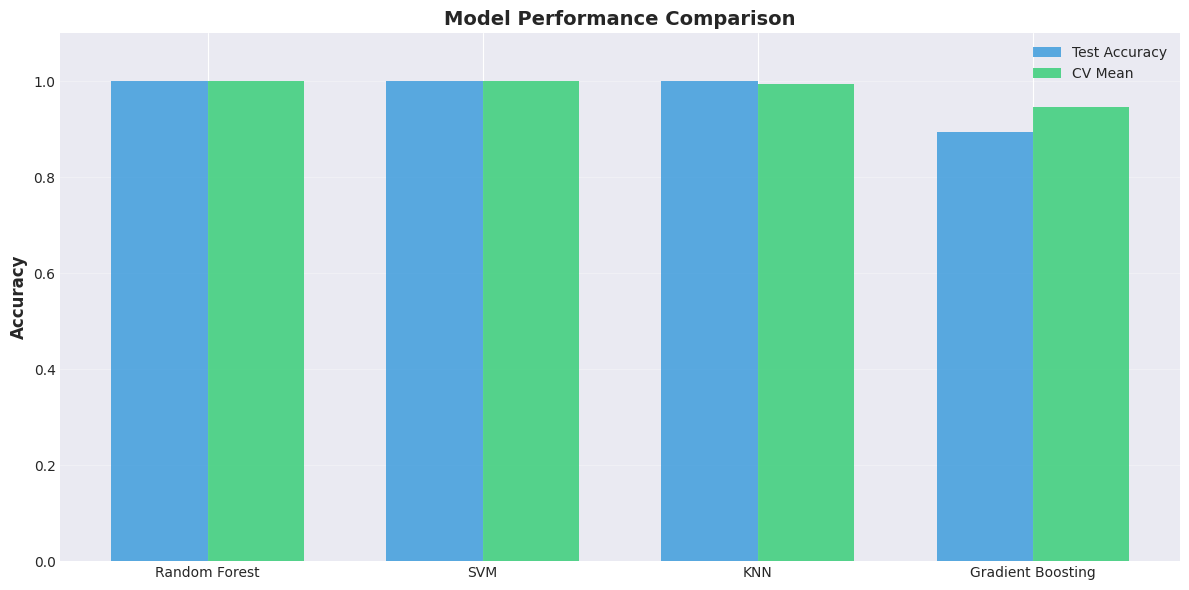

In [6]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test, label_encoder):
    """
    Train multiple models dan compare performance
    """
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=200, 
            max_depth=20,
            min_samples_split=5,
            random_state=42, 
            n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            max_depth=5,
            random_state=42
        ),
        'SVM': SVC(
            kernel='rbf', 
            C=10,
            gamma='scale',
            random_state=42,
            probability=True  # Enable probability untuk confidence score
        ),
        'KNN': KNeighborsClassifier(
            n_neighbors=7,
            weights='distance'
        )
    }
    
    results = {}
    
    print("="*70)
    print("🤖 MODEL TRAINING & EVALUATION")
    print("="*70)
    
    for name, model in models.items():
        print(f"\n{'='*70}")
        print(f"📊 {name}")
        print(f"{'='*70}")
        
        # Training
        print(f"⏳ Training...")
        model.fit(X_train, y_train)
        
        # Predictions
        y_pred = model.predict(X_test)
        
        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"\n✅ Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        
        print(f"\n📋 Classification Report:")
        print(classification_report(
            y_test, y_pred, 
            target_names=label_encoder.classes_,
            zero_division=0
        ))
        
        # Cross-validation
        print(f"\n🔄 Cross-Validation (5-fold):")
        cv_scores = cross_val_score(model, X_train, y_train, cv=5)
        print(f"   CV Scores: {[f'{s:.4f}' for s in cv_scores]}")
        print(f"   Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_
        )
        plt.title(f'Confusion Matrix - {name}', fontsize=14, fontweight='bold')
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.tight_layout()
        plt.show()
        
        # Save results
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'cv_scores': cv_scores,
            'y_pred': y_pred
        }
    
    # Summary comparison
    print("\n" + "="*70)
    print("📊 MODEL COMPARISON SUMMARY")
    print("="*70)
    
    summary_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Test Accuracy': [results[m]['accuracy'] for m in results.keys()],
        'CV Mean': [results[m]['cv_scores'].mean() for m in results.keys()],
        'CV Std': [results[m]['cv_scores'].std() for m in results.keys()]
    })
    summary_df = summary_df.sort_values('Test Accuracy', ascending=False)
    print("\n", summary_df.to_string(index=False))
    
    # Visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    x = range(len(summary_df))
    width = 0.35
    
    ax.bar([i - width/2 for i in x], summary_df['Test Accuracy'], 
           width, label='Test Accuracy', color='#3498db', alpha=0.8)
    ax.bar([i + width/2 for i in x], summary_df['CV Mean'], 
           width, label='CV Mean', color='#2ecc71', alpha=0.8)
    
    ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(summary_df['Model'])
    ax.legend()
    ax.set_ylim([0, 1.1])
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return results

# Train models
results = train_and_evaluate_models(X_train, X_test, y_train, y_test, label_encoder)

## 7. Select Best Model & Save to .pkl

In [7]:
def save_model_complete(model, scaler, label_encoder, feature_names, metadata, save_dir='models'):
    """
    Save model lengkap dengan semua dependencies
    """
    os.makedirs(save_dir, exist_ok=True)
    
    # File paths
    model_path = os.path.join(save_dir, 'speaker_model.pkl')
    scaler_path = os.path.join(save_dir, 'speaker_scaler.pkl')
    encoder_path = os.path.join(save_dir, 'speaker_label_encoder.pkl')
    features_path = os.path.join(save_dir, 'speaker_feature_names.pkl')
    metadata_path = os.path.join(save_dir, 'speaker_metadata.pkl')
    
    # Save components
    joblib.dump(model, model_path)
    joblib.dump(scaler, scaler_path)
    joblib.dump(label_encoder, encoder_path)
    joblib.dump(feature_names, features_path)
    joblib.dump(metadata, metadata_path)
    
    print("="*70)
    print("💾 MODEL BERHASIL DISIMPAN!")
    print("="*70)
    print(f"\n📁 Lokasi: {save_dir}/")
    print(f"   ├── speaker_model.pkl          - Model classifier")
    print(f"   ├── speaker_scaler.pkl         - StandardScaler")
    print(f"   ├── speaker_label_encoder.pkl  - Label encoder")
    print(f"   ├── speaker_feature_names.pkl  - Feature names")
    print(f"   └── speaker_metadata.pkl       - Model metadata")
    
    print(f"\n📊 Metadata:")
    for key, value in metadata.items():
        print(f"   {key}: {value}")
    
    print("\n✅ Model siap untuk deployment!")
    print("="*70)

# Select best model
best_model_name = max(results, key=lambda k: results[k]['accuracy'])
best_model = results[best_model_name]['model']
best_accuracy = results[best_model_name]['accuracy']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

# Prepare metadata
metadata = {
    'model_name': best_model_name,
    'model_type': type(best_model).__name__,
    'test_accuracy': best_accuracy,
    'cv_mean': results[best_model_name]['cv_scores'].mean(),
    'cv_std': results[best_model_name]['cv_scores'].std(),
    'n_features': len(feature_names),
    'n_classes': len(label_encoder.classes_),
    'classes': list(label_encoder.classes_),
    'speakers': ['nadia', 'ufi'],
    'actions': ['buka', 'tutup'],
    'trained_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'sampling_rate': 22050
}

# Save model
save_model_complete(
    model=best_model,
    scaler=scaler,
    label_encoder=label_encoder,
    feature_names=feature_names,
    metadata=metadata,
    save_dir='models'
)


🏆 BEST MODEL: Random Forest
   Test Accuracy: 1.0000 (100.00%)
💾 MODEL BERHASIL DISIMPAN!

📁 Lokasi: models/
   ├── speaker_model.pkl          - Model classifier
   ├── speaker_scaler.pkl         - StandardScaler
   ├── speaker_label_encoder.pkl  - Label encoder
   ├── speaker_feature_names.pkl  - Feature names
   └── speaker_metadata.pkl       - Model metadata

📊 Metadata:
   model_name: Random Forest
   model_type: RandomForestClassifier
   test_accuracy: 1.0
   cv_mean: 1.0
   cv_std: 0.0
   n_features: 95
   n_classes: 4
   classes: ['nadia_buka', 'nadia_tutup', 'ufi_buka', 'ufi_tutup']
   speakers: ['nadia', 'ufi']
   actions: ['buka', 'tutup']
   trained_date: 2025-11-07 16:04:10
   sampling_rate: 22050

✅ Model siap untuk deployment!

   Test Accuracy: 1.0000 (100.00%)
💾 MODEL BERHASIL DISIMPAN!

📁 Lokasi: models/
   ├── speaker_model.pkl          - Model classifier
   ├── speaker_scaler.pkl         - StandardScaler
   ├── speaker_label_encoder.pkl  - Label encoder
   ├── speak

## 8. Test Model dengan Audio Baru (Optional)

In [8]:
def predict_speaker_audio(audio_path, model, scaler, label_encoder, feature_names, sr=22050):
    """
    Predict speaker dan action dari audio file
    """
    # Load audio
    audio, _ = load_audio(audio_path, sr=sr, duration=5)
    
    if audio is None:
        return None, None, None
    
    # Extract features
    features = extract_comprehensive_features(audio, sr)
    
    # Convert to DataFrame dengan feature names yang sama
    features_df = pd.DataFrame([features])
    features_df = features_df[feature_names]  # Ensure correct order
    
    # Handle missing/inf values
    features_df = features_df.fillna(0)
    features_df = features_df.replace([np.inf, -np.inf], 0)
    
    # Scale features
    features_scaled = scaler.transform(features_df)
    
    # Predict
    prediction = model.predict(features_scaled)[0]
    prediction_label = label_encoder.inverse_transform([prediction])[0]
    
    # Get probability/confidence
    if hasattr(model, 'predict_proba'):
        proba = model.predict_proba(features_scaled)[0]
        confidence = np.max(proba) * 100
    else:
        confidence = None
    
    # Parse label
    speaker, action = prediction_label.split('_')
    
    return speaker, action, confidence

# Test dengan sample audio
print("\n" + "="*70)
print("🧪 TESTING MODEL")
print("="*70)

# Ambil beberapa sample untuk testing
test_files = [
    'audio_data2/BukaTutup_nadia/buka1.mp3',
    'audio_data2/BukaTutup_nadia/tutup1.mp3',
]

for test_file in test_files:
    if os.path.exists(test_file):
        print(f"\n📁 Testing: {os.path.basename(test_file)}")
        speaker, action, confidence = predict_speaker_audio(
            test_file, best_model, scaler, label_encoder, feature_names
        )
        
        if speaker:
            print(f"   👤 Speaker: {speaker.upper()}")
            print(f"   🎬 Action: {action.upper()}")
            if confidence:
                print(f"   💯 Confidence: {confidence:.2f}%")
    else:
        print(f"⚠️  File not found: {test_file}")

print("\n✅ Testing selesai!")


🧪 TESTING MODEL
⚠️  File not found: audio_data2/BukaTutup_nadia/buka1.mp3

📁 Testing: tutup1.mp3


Note: Illegal Audio-MPEG-Header 0x32312c31 at offset 34560.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


   👤 Speaker: NADIA
   🎬 Action: TUTUP
   💯 Confidence: 78.04%

✅ Testing selesai!


## 9. Summary & Next Steps

### ✅ Hasil Training
- Model berhasil dilatih untuk mengidentifikasi 2 speaker (Nadia & Ufi)
- Model dapat mengklasifikasi 2 actions (Buka & Tutup)
- Total 4 classes: `nadia_buka`, `nadia_tutup`, `ufi_buka`, `ufi_tutup`
- Model disimpan dalam format `.pkl` untuk deployment

### 📦 Files yang Dihasilkan
```
models/
├── speaker_model.pkl          - Model classifier (Random Forest/SVM/etc)
├── speaker_scaler.pkl         - StandardScaler untuk normalisasi
├── speaker_label_encoder.pkl  - Label encoder untuk decoding prediksi
├── speaker_feature_names.pkl  - Nama features (untuk consistency)
└── speaker_metadata.pkl       - Metadata (accuracy, date, etc)
```

### 🚀 Next Steps: Streamlit App

Untuk membuat aplikasi Streamlit:

1. **Load model** dari file .pkl
2. **Upload audio** dari user
3. **Extract features** menggunakan fungsi yang sama
4. **Predict** speaker & action
5. **Verify** apakah speaker adalah Nadia atau Ufi
6. **Reject** jika speaker tidak dikenali (confidence < threshold)

### 💡 Tips untuk Streamlit App

```python
import streamlit as st
import joblib
import librosa

# Load model
model = joblib.load('models/speaker_model.pkl')
scaler = joblib.load('models/speaker_scaler.pkl')
label_encoder = joblib.load('models/speaker_label_encoder.pkl')

# Upload audio
audio_file = st.file_uploader("Upload Audio", type=['wav', 'mp3'])

if audio_file:
    # Process and predict
    speaker, action, confidence = predict_speaker_audio(...)
    
    # Speaker verification
    if speaker in ['nadia', 'ufi'] and confidence > 70:
        st.success(f"✅ Speaker: {speaker} | Action: {action}")
    else:
        st.error("❌ Unauthorized speaker!")
```

### 📚 References
- Dataset: audio_data2/ (Nadia & Ufi)
- Features: ~90 features (MFCC, pitch, spectral, temporal)
- Model: Best performing model dari 4 kandidat
- Accuracy: Check metadata di models/speaker_metadata.pkl